Students:

Joana Rodrigues - 20240603    
Maria Francisca - 20240346     
Rui Reis - 20240854      
Tomás Silva - 20230982     
Victor Pita - 20240596        

# Project Part 4 - Model tuning with Cross validation

This thrid part contains the tuning of the model. In other words, cross validation is done in the best model registered in the previous notebook and some strategies to fight class imbalance are tried.

# Index 
1. [Imports](#imports)   
    1.1. [Import Libraries](#importlibraries)    
    1.2. [Import Data files](#importfiles)
2. [Data exploration and Preprocessing](#data)   
    2.1. [Define index](#index)    
    2.2. [Dataset columns](#columns)  
    2.3. [Functions](#functions)   
    2.4. [New Features](#newfeatures)       
    2.5. [1st Exploration: Univariate Distributions](#1stexploration)     
    2.6. [EDA](#eda)    
    2.7. [Univariate EDA: Descriptive Summary](#descriptivesummary)     
    2.8. [Univariate EDA: Missing Values](#missingvalues)     
    2.9. [Univariate EDA: Categorical & Numerical](#categoricalnumerical)       
    2.9.1. [Categorical - Distributions](#categoricaldistributions)            
    2.9.2. [Numerical - Distributions](#numericaldistributions)        
    2.10. [Multivariate EDA: Categorical & Numerical](#multivariateeda)      
    2.10.1. [Numerical - Categorical - KDE Plots](#kdeplots)       
    2.10.2. [Categorical - Categorical - Plots](#categoricalplots)        
    2.10.3. [Numerical - Numerical - Plots](#numericalplots)           

`Accident Date` Injury date of the claim   
`Age at Injury Age` of injured worker when the injury occurred.  
`Alternative Dispute Resolution` Adjudication processes external to the Board.   
`Assembly Date` The date the claim was first assembled.   
`Attorney/ Representative` Is the claim being represented by an Attorney?   
`Average Weekly Wage ` The wage used to calculate workers’ compensation, disability, or an Paid Leave wage replacement benefits.      
`Birth Year` The reported year of birth of the injured worker.   
`C-2 Date` Date of receipt of the Employer's Report of Work-Related; Injury/Illness or equivalent (formerly Form C-2).   
`C-3 Date` Date Form C-3 (Employee Claim Form) was received.   
`Carrier Name`Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker’s employer.   
`Carrier Type` Type of primary insurance provider responsible for providing workers’ compensation coverage.   
`Claim Identifier` Unique identifier for each claim, assigned by WCB.   
`County of Injury` Name of the New York County where the injury occurred.   
`COVID-19 Indicator` Indication that the claim may be associated with COVID-19.   
`District Name` Name of the WCB district office that oversees claims for that region or area of the state.   
`First Hearing Date` Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.    
`Gender` The reported gender of the injured worker.   
`IME-4 Count` Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.   
`Industry Code` NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.   
`Industry Code Description` 2-digit NAICS industry code description used to classify businesses according to their economic activity.   
`Medical Fee Region` Approximate region where the injured worker would receive medical service.   
`OIICS Nature of Injury Description` The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.   
`WCIO Cause of Injury Code` The WCIO cause of injury codes & descriptions are at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf   
`WCIO Cause of Injury Description` See description of field above.    
`WCIO Nature of Injury Code` The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf   
`WCIO Nature of Injury Description`See description of field above.   
`WCIO Part Of Body Code` The WCIO part of body codes & descriptions are available athttps://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf   
`WCIO Part Of Body Description` See description of field above.   
`Zip Code` The reported ZIP code of the injured worker’s home address.   
`Agreement Reached` Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.   
`WCB Decision` Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.    
`Claim Injury Type` Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity   

<hr>
<a class="anchor" id="imports">
    
# 1. Import
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 1.1. Import libraries
</a>

In [25]:
import pandas as pd 
import numpy as np 
import warnings
import itertools
import math
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
import category_encoders as ce
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
import hdbscan
import matplotlib.pyplot as plt


In [26]:
warnings.filterwarnings('ignore')

<hr>
<a class="anchor" id="importfiles">
    
## 1.2. Import data files
</a>

In [27]:
df_train = pickle.load(open("df_train_cleaned.pkl", 'rb'))
df_test = pickle.load(open("df_test_cleaned.pkl", 'rb'))
features_selected = pickle.load(open("all_features.pkl", 'rb')) # features selected in the previous notebook

FileNotFoundError: [Errno 2] No such file or directory: 'all_features.pkl'

Separation of target and other variables and encoding of the target.        
Labelencoder is used in this case as the 'Claim Injury Type' can be considered ordinal because there are injury types worse than others.

In [ ]:
X = df_train.drop(columns=['Claim Injury Type'])  # Features
y = df_train['Claim Injury Type']  # Target column
target_le = LabelEncoder()
target_le.fit(y)
y = pd.Series(target_le.transform(y))

Feature selection     
To understand if the CV works better than the standard data split we use the same features as were used in the previous notebook

In [ ]:
df_test.shape

In [ ]:
X = X[features_selected]
df_test = df_test[features_selected]

### Function that defines the feature types      
(Same function as in the previous notebooks)

In [ ]:
def identify_feature_types(df):
    # Identifying date features
    date_features = [column for column in df.columns if 'Date' in column]
    
    # Identifying categorical (object) features initially
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Identifying boolean features
    boolean_features = df.select_dtypes(include=['bool']).columns.tolist()
    
    # Identifying numerical features (integers and floats), but excluding those with 'Code', 'County', or 'Carrier' in their name
    numerical_features = [
        column for column in df.select_dtypes(include=['int64', 'float64']).columns
        if 'Code' not in column and 'County' not in column and 'Carrier' not in column and 'Decision' not in column and 'Indicator' not in column  and 'Grouped' not in column
    ]
    
    # Adding features with 'Code', 'County', or 'Carrier' in the name to categorical features, even if they are numerical
    categorical_features.extend([
        column for column in df.columns if 'Code' in column or 'County' in column or 'Carrier' in column or 'Decision' in column or 'Grouped' in column
    ])

    # Removing duplicates in case any feature is accidentally added twice
    categorical_features = list(set(categorical_features))
    
    return {
        'date_features': date_features,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'boolean_features': boolean_features
    }


### Function that handles the missing values      
For the numerical columns it replaces them with the median due to not having removed the outliers, this value seems a better approach    
For the categorical columns we substitute the missing values with the mode. Initially, we thought about substituting the missing values of the categoricals according to the mode for each type of injury but as there are not a lot of missing values in this stage, we went for a simpler approach.

In [ ]:
def handle_missing_values(X_train, X_val, df_test):
    # Identify feature types
    feature_types = identify_feature_types(X_train)
    
    # For numerical columns: fill NaN with the median value (to avoid outlier influence)
    numerical_features = feature_types['numerical_features']
    
    for column in numerical_features:
        if column in X_train.columns:
            # Use the median value of the training set for filling missing values
            median_value = X_train[column].median()  # Using median to handle potential outliers
            X_train[column] = X_train[column].fillna(median_value)
            X_val[column] = X_val[column].fillna(median_value)
            df_test[column] = df_test[column].fillna(median_value)

    # For categorical columns: fill NaN with the mode (most frequent value)
    categorical_features = feature_types['categorical_features']
    
    for column in categorical_features:
        if column in X_train.columns:
            # Use the mode value of the training set for filling missing values
            mode_value = X_train[column].mode()[0]  # Find the mode (most frequent value) for each categorical column
            X_train[column] = X_train[column].fillna(mode_value)
            X_val[column] = X_val[column].fillna(mode_value)
            df_test[column] = df_test[column].fillna(mode_value)

    # print("Columns with missing values in X_train:")
    # print(X_train.columns[X_train.isna().any()].tolist())  # Using .any() to check for any NaNs in each column
    # print("Columns with missing values in X_val:")
    # print(X_val.columns[X_val.isna().any()].tolist())
    # print("Columns with missing values in df_test:")
    # print(df_test.columns[df_test.isna().any()].tolist())
    return X_train, X_val, df_test


### Encoder
The encoder chosen was CountEncoder because it represents categorical values based on their frequency, providing a meaningful numerical encoding. Unlike other encoders that assign arbitrary numbers to categories, CountEncoder avoids the risk of introducing misleading patterns or biases into the model, which could potentially mislead the algorithm.

In [ ]:
def check_placeholders(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        print(f"Column: {col}")
        print(f"Unique values: {unique_vals}")
        print("-" * 50)

def encoder(X_train, X_val, df_test):
    # Identify categorical columns
    columns_to_encode = [col for col in X_train.columns if X_train[col].dtype == 'object']
    encoder = ce.CountEncoder()

    # Create copies of the input DataFrames to avoid modifying the originals
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy()
    X_test_encoded = df_test.copy()

    for col in columns_to_encode:
        # Fit encoder only on the training set
        encoder.fit(X_train[[col]])

        # Transform the training, validation, and test sets using the same encoding
        X_train_encoded[col] = encoder.transform(X_train[[col]])
        X_val_encoded[col] = encoder.transform(X_val[[col]]).fillna(0)  # Handle unseen categories in validation
        X_test_encoded[col] = encoder.transform(df_test[[col]]).fillna(0)  # Handle unseen categories in test

    # check_placeholders(X_train_encoded)
    # check_placeholders(X_val_encoded)
    # check_placeholders(X_test_encoded)
    # print(X_train_encoded.dtypes)
    # print(X_val_encoded.dtypes)
    # print(X_test_encoded.dtypes)


    return X_train_encoded, X_val_encoded, X_test_encoded


### Scaler
The scaler chosen was MinMaxScale because, even though there were some outliers in the data, the transformation made to log features helped reduce this differences and therefore the outliers are not extreme. Furthermore, this scaler also works well with data that does not follow a normal distribution

In [ ]:
def scaler(X_train, X_val, df_test):
    metric_features = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]

    # Scale numeric features
    scaler = MinMaxScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = df_test.copy()

    X_train_scaled[metric_features] = scaler.fit_transform(X_train)
    X_val_scaled[metric_features] = scaler.transform(X_val)
    X_test_scaled[metric_features] = scaler.transform(X_test_scaled)

    return X_train_scaled, X_val_scaled, X_test_scaled

### Evaluation of model
This function is to be incorporated to understand if the changes made in the models worked for the better or not.
It allows to see if the classes are being well predicted and if not if they are being predicted at all or not.

In [ ]:
def evaluate_model_predictions(y_pred_train, y_pred_val, y_train, y_val):
    # Calculate performance metrics for training and testing
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1_macro = f1_score(y_train, y_pred_train, average='macro')
    
    test_accuracy = accuracy_score(y_val, y_pred_val)
    test_f1_macro = f1_score(y_val, y_pred_val, average='macro')

    # Display results
    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"Accuracy of test: {test_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1_macro:.4f}")
    print(f"\033[1mF1 Macro (Test)\033[0m: {test_f1_macro:.4f}")
    
    print("\nClassification Report for Validation Data:")
    print(classification_report(y_val, y_pred_val))

    print("\Confusion Matrix for Validation Data:")
    print(confusion_matrix(y_val, y_pred_val))
    return train_accuracy, train_f1_macro, test_accuracy, test_f1_macro

### HDBSCAN for undersampling
Since the outliers were not removed initially, we decided to address them by removing the outliers for each injury type class separately. This approach helps ensure that each injury type has more consistent values and prevents confusion with other injury types, where outliers might resemble the values of different classes.

In [13]:
def outliers_remover(X_train, y_train):
    # Combine X_train and y_train into a single DataFrame for easier processing
    data_train = pd.DataFrame(X_train)
    data_train['Claim Injury Type'] = y_train  # Add the target variable

    # Select only numeric columns from the dataset
    numeric_columns = data_train.select_dtypes(include=['number']).columns.tolist()

    # Ensure the target column 'Claim Injury Type' is excluded from numeric columns
    numeric_columns = [col for col in numeric_columns if col != 'Claim Injury Type']
    data_train = data_train[numeric_columns + ['Claim Injury Type']]  # Reorganize columns

    # Initialize a dictionary to store the count of outliers by class
    outliers_per_class = {}
    outlier_indices_to_drop = []  # List to collect indices of outliers

    # Iterate over each class, except 5, 6, and 7
    for injury_type in [0,1, 2, 3, 4]:  
        # Select the data for the current class
        class_data = data_train[data_train['Claim Injury Type'] == injury_type]
        X_class = class_data.drop(columns=['Claim Injury Type'])  # Only the features

        # Apply HDBSCAN
        dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=5)  # Adjust parameters if needed
        labels = dbscan.fit_predict(X_class)

        # Count the number of outliers (labels == -1 are outliers in HDBSCAN)
        outliers_count = (labels == -1).sum()

        # Store the count of outliers for the class
        outliers_per_class[injury_type] = outliers_count

        # Add the indices of outliers to the list for removal
        outlier_indices = class_data.index[labels == -1]
        outlier_indices_to_drop.extend(outlier_indices)

    # Display the number of outliers identified per class
    print("Number of outliers identified per class (except 5, 6, 7):")
    for injury_type, count in outliers_per_class.items():
        print(f"Class {injury_type}: {count} outliers identified")

    # Remove the identified outliers from the data
    df_DBSCAN = data_train.drop(index=outlier_indices_to_drop)

    # Separate the features and target variables after removing outliers
    X_train_DBSCAN = df_DBSCAN.drop(columns=['Claim Injury Type'])
    y_train_DBSCAN = df_DBSCAN['Claim Injury Type']

    # Show the shape of the new data
    print(f"Shape of X_train after removing outliers: {X_train_DBSCAN.shape}")

    return X_train_DBSCAN, y_train_DBSCAN

### Cross-validation function
The following function performs cross-validation on the model chosen, evaluating its performance on multiple splits of training and validation data.     
It initializes a StratifiedKFold cross-validation with 3 splits. For each fold, the function splits the data into training and validation sets, handles missing values, encodes categorical variables, and scales the features (with the functions previously set).    
Optionally, it applies some techniques of undersampling and oversampling.
If specified the function will apply the previous function on the model (to remove the outliers per class with HDBSCAN) and if specified it will do a SMOTE for the smallest class (6).     
After each fold, it measures the time taken and evaluates the model’s predictions for both training and validation data.    
Finally, the function predicts on the test set and returns these predictions, to use for the submission file.

In [14]:
def avg_score(model, X, y, df_test, feature_selection=False, smote=False, hdbscan= False):
    skf = StratifiedKFold(n_splits=3)
    timer = []
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        begin = time.perf_counter()

        handle_missing_values(X_train, X_val, df_test)
        
        X_train_encoded, X_val_encoded, X_test_encoded = encoder(X_train, X_val, df_test)
        X_train_scaled, X_val_scaled, X_test_scaled = scaler(X_train_encoded, X_val_encoded, X_test_encoded)
        
        if hdbscan:
            X_train_scaled, y_train = outliers_remover(X_train_scaled, y_train)

        if smote:
            oversampler = SMOTE(sampling_strategy={6: 6000}, random_state=42)
            X_train_scaled, y_train = oversampler.fit_resample(X_train_scaled, y_train)

        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)  # Predições no conjunto de treino
        y_pred_val = model.predict(X_val_scaled)  # Predições no conjunto de validação
        end = time.perf_counter()

        timer.append(end - begin)

        print(f"Fold duration: {end - begin:.2f}s")
    train_accuracy, train_f1_macro, test_accuracy, test_f1_macro = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train, y_val=y_val)

    y_pred_test = model.predict(X_test_scaled)
    
    print("Predictions completed.")
    return y_pred_test, train_accuracy, train_f1_macro, test_accuracy, test_f1_macro


### Model chosen
The model chosen is taking into account the previous notebooks' results.    
XGBoost seemed to be the best model to predict our data and therefore will be explored further in this notebook with cross-validation.

In [15]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))
xgb = XGBClassifier(
    scale_pos_weight=class_weights_dict,  # Usando dicionário de pesos de classes
    n_estimators=100,  # Número de rodadas de boosting ajustado para 100
    learning_rate=0.2,  # Taxa de aprendizado ajustada para 0.2
    random_state=42,
    subsample=1.0,  # Manter a proporção de amostragem como 1.0
    reg_lambda=10,  # Regularização L2
    reg_alpha=0,  # Regularização L1
    min_child_weight=7,  # Ajuste para a soma mínima de pesos em uma criança
    max_depth=9,  # Profundidade máxima da árvore
    gamma=0.1,  # Redução mínima de perda necessária
    colsample_bytree=0.6  # Proporção de features para considerar ao construir cada árvore
)


### XGB simple model
Trying the model that proved to be the best from the previous notebook with cross validation.    
For comparison purposes this model is simple with no undersampling or oversampling.

In [16]:
y_pred_test_xgb, train_accuracy_xgb, train_f1_macro_xgb, test_accuracy_xgb, test_f1_macro_xgb = avg_score(model=xgb, X=X, y=y, df_test=df_test)

Fold duration: 83.53s
Fold duration: 52.44s
Fold duration: 61.14s
Accuracy of train: 0.8215
Accuracy of test: 0.7691
F1 Macro (Train): 0.4953
F1 Macro (Test): 0.4196

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.79      0.43      0.56      3587
           1       0.86      0.97      0.91     95994
           2       0.29      0.16      0.21     22880
           3       0.76      0.76      0.76     49304
           4       0.60      0.60      0.60     16083
           5       0.00      0.00      0.00      1402
           6       0.00      0.00      0.00        33
           7       0.66      0.21      0.32       155

    accuracy                           0.77    189438
   macro avg       0.49      0.39      0.42    189438
weighted avg       0.73      0.77      0.75    189438

\Confusion Matrix for Validation Data:
[[ 1550  1768   233    28     8     0     0     0]
 [  339 93433  1947   237    35     0     0     3

### XGB with RandomUnderSampler
As some of the classes are highly representative of the dataset, we use the RandomUnderSampler technique to address class imbalance by randomly undersampling the majority classes, ensuring a more balanced distribution of classes for model training.

In [17]:
# Check the original class distribution
print("Original class distribution:", Counter(y))

# Apply RandomUnderSampler to reduce the size of majority classes
under_sampler = RandomUnderSampler(sampling_strategy={1: 150000, 3: 40000, 2: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97}, random_state=42)

# Fit the undersampling model to the data
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Check the class distribution after undersampling
print("Distribution after undersampling:", Counter(y_resampled))

# Run the model
y_pred_test_xgbrus, train_accuracy_xgbrus, train_f1_macro_xgbrus, test_accuracy_xgbrus, test_f1_macro_xgbrus = avg_score(model=xgb, X=X_resampled, y=y_resampled, df_test=df_test)

Original class distribution: Counter({1: 287984, 3: 147911, 2: 68640, 4: 48248, 0: 10761, 5: 4207, 7: 466, 6: 97})
Distribution after undersampling: Counter({1: 150000, 2: 40000, 3: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97})
Fold duration: 27.33s
Fold duration: 23.62s
Fold duration: 41.00s
Accuracy of train: 0.8082
Accuracy of test: 0.7715
F1 Macro (Train): 0.5810
F1 Macro (Test): 0.4669

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.77      0.46      0.58      2666
           1       0.84      0.98      0.91     50000
           2       0.50      0.16      0.24     13334
           3       0.66      0.74      0.69     13333
           4       0.67      0.79      0.73     10000
           5       0.36      0.07      0.12      1402
           6       0.00      0.00      0.00        33
           7       0.61      0.39      0.47       155

    accuracy                           0.77     90923
   macro avg   

### XGB with SMOTE and RandomUnderSampler
As previously seen the model made is having a hard time predicting some of the minority classes, to try to avoid this, we develop a model with undersampling of the minority classes through randomundersampling and oversampling of the class 6 through SMOTE (as class 6 is harder to predict than 5).       
(SMOTE-ENN was also tried as it was in the previous notebook but didn't obtain as good results)

In [18]:
# Check the original class distribution
print("Original class distribution:", Counter(y))

# Apply RandomUnderSampler to reduce the size of majority classes
under_sampler = RandomUnderSampler(sampling_strategy={1: 150000, 3: 40000, 2: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97}, random_state=42)

# Fit the undersampling model to the data
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Check the class distribution after undersampling
print("Distribution after undersampling:", Counter(y_resampled))

# Run the model
y_pred_test_xgbrussmote, train_accuracy_xgbrussmote, train_f1_macro_xgbrussmote, test_accuracy_xgbrussmote, test_f1_macro_xgbrussmote = avg_score(model=xgb, X=X_resampled, y=y_resampled, df_test=df_test, smote= True)

Original class distribution: Counter({1: 287984, 3: 147911, 2: 68640, 4: 48248, 0: 10761, 5: 4207, 7: 466, 6: 97})
Distribution after undersampling: Counter({1: 150000, 2: 40000, 3: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97})
Fold duration: 26.59s
Fold duration: 27.87s
Fold duration: 27.22s
Accuracy of train: 0.8142
Accuracy of test: 0.7720
F1 Macro (Train): 0.7067
F1 Macro (Test): 0.4684

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.77      0.46      0.58      2666
           1       0.84      0.98      0.91     50000
           2       0.50      0.16      0.24     13334
           3       0.66      0.74      0.70     13333
           4       0.67      0.79      0.72     10000
           5       0.34      0.07      0.12      1402
           6       0.00      0.00      0.00        33
           7       0.62      0.39      0.48       155

    accuracy                           0.77     90923
   macro avg   

### XGB with SMOTE, RandomUnderSampler and HDBSCAN
As the model in the previous notebook showed better results with HDBSCAN we try this approach.

In [19]:
# Check the original class distribution
print("Original class distribution:", Counter(y))

# Apply RandomUnderSampler to reduce the size of majority classes
under_sampler = RandomUnderSampler(sampling_strategy={1: 150000, 3: 40000, 2: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97}, random_state=42)

# Fit the undersampling model to the data
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Check the class distribution after undersampling
print("Distribution after undersampling:", Counter(y_resampled))

# Run the model
y_pred_test_xgbrussmotehdbscan, train_accuracy_xgbrussmotehdbscan, train_f1_macro_xgbrussmotehdbscan, test_accuracy_xgbrussmotehdbscan, test_f1_macro_xgbrussmotehdbscan = avg_score(model=xgb, X=X_resampled, y=y_resampled, df_test=df_test, smote= True, hdbscan=True)

Original class distribution: Counter({1: 287984, 3: 147911, 2: 68640, 4: 48248, 0: 10761, 5: 4207, 7: 466, 6: 97})
Distribution after undersampling: Counter({1: 150000, 2: 40000, 3: 40000, 4: 30000, 0: 8000, 5: 4207, 7: 466, 6: 97})
Number of outliers identified per class (except 5, 6, 7):
Class 0: 518 outliers identified
Class 1: 31481 outliers identified
Class 2: 8026 outliers identified
Class 3: 4606 outliers identified
Class 4: 5912 outliers identified
Shape of X_train after removing outliers: (131303, 16)
Fold duration: 1167.56s
Number of outliers identified per class (except 5, 6, 7):
Class 0: 540 outliers identified
Class 1: 31373 outliers identified
Class 2: 8026 outliers identified
Class 3: 6795 outliers identified
Class 4: 5150 outliers identified
Shape of X_train after removing outliers: (129963, 16)
Fold duration: 1050.38s
Number of outliers identified per class (except 5, 6, 7):
Class 0: 831 outliers identified
Class 1: 32316 outliers identified
Class 2: 8067 outliers iden

In [20]:
# Define model results for different class imbalance techniques
model_results = {
    'Model with Technique': [
        'XGB', 
        'XGB + RUS', 
        'XGB + RUS + SMOTE', 
        'XGB + RUS + SMOTE + HDBSCAN'
    ],
    'Train Accuracy': [
        train_accuracy_xgb, 
        train_accuracy_xgbrus, 
        train_accuracy_xgbrussmote, 
        train_accuracy_xgbrussmotehdbscan
    ],
    'Test Accuracy': [
        test_accuracy_xgb, 
        test_accuracy_xgbrus, 
        test_accuracy_xgbrussmote, 
        test_accuracy_xgbrussmotehdbscan
    ],
    'Train F1 Score': [
        train_f1_macro_xgb, 
        train_f1_macro_xgbrus, 
        train_f1_macro_xgbrussmote, 
        train_f1_macro_xgbrussmotehdbscan
    ],
    'Test F1 Score': [
        test_f1_macro_xgb, 
        test_f1_macro_xgbrus, 
        test_f1_macro_xgbrussmote, 
        test_f1_macro_xgbrussmotehdbscan
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Model with Technique' as the index
results_models.set_index('Model with Technique', inplace=True)

# Display the DataFrame with results
results_models


,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
Model with Technique,,,,
XGB,0.821548,0.769075,0.495305,0.419623
XGB + RUS,0.808207,0.771499,0.580978,0.466855
XGB + RUS + SMOTE,0.814227,0.771972,0.706715,0.468364
XGB + RUS + SMOTE + HDBSCAN,0.826990,0.762986,0.739042,0.468411


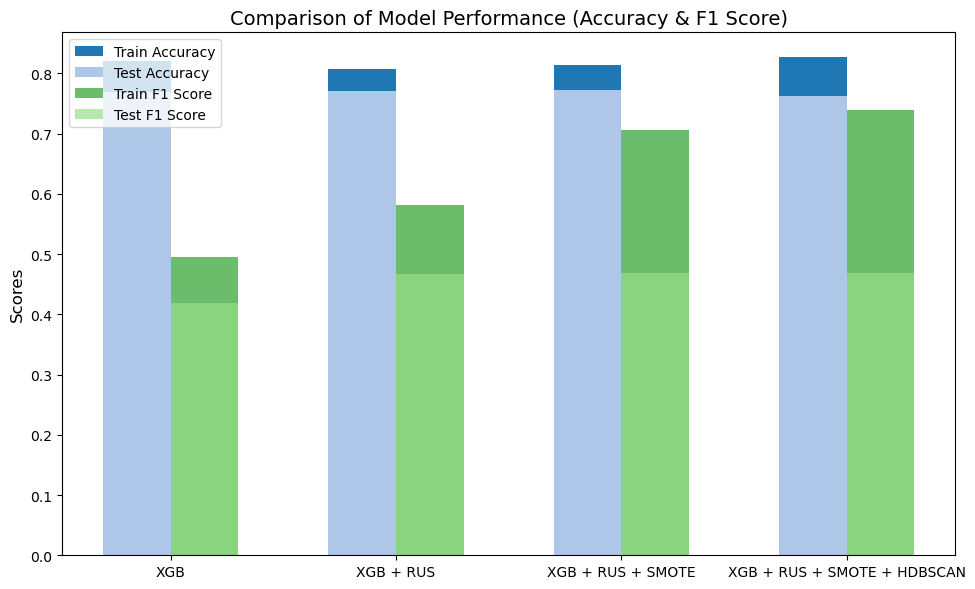

In [24]:
# Set model names from the 'results_models' DataFrame
model_names = results_models.index

# Accuracy and F1 scores from the results DataFrame
train_accuracy = results_models['Train Accuracy']
test_accuracy = results_models['Test Accuracy']
train_f1 = results_models['Train F1 Score']
test_f1 = results_models['Test F1 Score']

# Bar width
bar_width = 0.3
index = np.arange(len(model_names))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Train Accuracy, Test Accuracy, Train F1 Score, and Test F1 Score
bar_tra = ax.bar(index - bar_width / 2, train_accuracy, bar_width, label='Train Accuracy', color='#1F77B4' )
bar_ta = ax.bar(index - bar_width / 2, test_accuracy, bar_width, label='Test Accuracy', color='#AEC7E8')

bar_trf = ax.bar(index + bar_width / 2, train_f1, bar_width, label='Train F1 Score', alpha=0.7, color= '#2CA02C' )
bar_tf = ax.bar(index + bar_width / 2, test_f1, bar_width, label='Test F1 Score', alpha=0.7, color='#98DF8A')

# Labeling the plot
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance (Accuracy & F1 Score)', fontsize=14)

# Set the model names on the x-axis from 'results_models' index
ax.set_xticks(index)
ax.set_xticklabels(model_names)

# Display the legend
ax.legend()

# Show the plot with tight layout to ensure no labels are cut off
plt.tight_layout()
plt.show()


To store the results in an excel spreadsheet.    
The model chosen as the best is 'XGB with RandomUnderSampler' as it presents a high f1 score and lower overfitting in comparison to the other models tried in this notebook.

In [ ]:
predict = target_le.inverse_transform(list(y_pred_test_xgbrus))

# Prepare the DataFrame for submission
ids = pd.DataFrame(df_test.index)  # Extract IDs from the test set
predict_df = pd.DataFrame(predict, columns=['Claim Injury Type'])

# Combine IDs and predictions for final submission
final = pd.concat([ids, predict_df], axis=1)

# Reset index and save to CSV
final.reset_index(drop=True, inplace=True)
final.to_csv('submission.csv', index=False)